# Figure Reproducibility Assignment
## MSU D2L Instructor API

This notebook was created for the Figure Reproducibility Assignment for the Spring 2023 Data Science Capstone (CMSE495), and was submitted on 03/26/2023. 

Our core project does not have a clear need for visualization, however, we know that visualization is a key part of any data scientist's work, and wanted to use this milestone as an opportunity to provide extra functionality to our sponsors. This being said, to decide what kind of visualization to make we asked our sponsors if there are any visualizations or graphs that aren't already available in the D2L interface (or are availiable but not optimized) that may be helpful to instructors and researchers using our project! They said that they thought a graph showing the frequency of students' overall quiz scores would likely be the most valuable. We took this insight and decided to run with it, creating an interactive visualization that shows the frequency of scores for the full quiz, and each question, based on the value selected in an interactive dropdown. This will likely be incoporated as extra functionality in our D2L library. 

You will need to run all cells in this notebook to generate the visualization, however, you may not be interested in reviewing all sections of the notebook (i.e. data cleaning). To just see the visualization, please bring in data in the "Bringing in Data Files" section, and then you can proceed to the "Visualization" section of this notebook. You will still need to run the previous cells to make sure these sections work. 

## Data and Dependencies

To use this notebook, you must have two datasets: the quiz data and the answer key for that quiz, both from D2L. For this example, we reccommend using our deidentified sample data, which can be found in the "FigureReproducibility" section of our repository (https://gitlab.msu.edu/sawyerer/d2l-instructor-api/-/tree/main/FigureReproducibility). The files are named "FigureReproducibilityExampleData_QuizAttemptDetails.csv" ( https://gitlab.msu.edu/sawyerer/d2l-instructor-api/-/blob/main/FigureReproducibility/FigureReproducibilityExampleData_QuizAttemptDetails.csv ) and "FigureReproducibilityExampleData_AnswerKey.csv" ( https://gitlab.msu.edu/sawyerer/d2l-instructor-api/-/blob/main/FigureReproducibility/FigureReproducibilityExampleData_AnswerKey.csv ). Please ensure that these are downloaded to your local machine in the same directory as this notebook. 

You must also have the necessary packages installed, which are imported below. The packages are: pandas, numpy, ipywidgets, and matplotlib.  It is assumed that you already have python and Jupyter Notebooks set up for this notebook, but our "INSTALL.md" can help with that process if they are not already installed. our install file can be found here: https://gitlab.msu.edu/sawyerer/d2l-instructor-api/-/blob/main/INSTALL.md

In [29]:
# Imports

# importing pandas library
import pandas as pd

# importing numpy library
import numpy as np

# importing ipywidget library
import ipywidgets as widgets

# importing matplotlib library
import matplotlib.pyplot as plt
# reference, matplotlib documentation for barplot: 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

## Data Cleaning

The data cleaning code is necessary for creating our figures from the dataset. In the future, this may be more streamlined as we work on packaging it into a library, and will come with more thorough instructions. However, this was less of a focus for this particular milestone. 

### Function Definitions

The following code block contains our function definitions for the data cleaning portion of our project. They are important for getting the data ready to visualized, but you can just run the cell and move forward. 

In [80]:
# RUN THIS CELL AND MOVE ON

# user_attempt is the data that you are attempting to transform/ modified (with answer key) question details file
# quiz answer is the answer key/question details file

# This creates a unique order of questions for every quiz. 
def createQuizOrder(user_attempt, quiz_answer): 
    d = dict(enumerate(quiz_answer["Q Text"].unique(),1))
    reversed_d = dict([(value, key) for key, value in d.items()])
    user_attempt["newQ#"] = user_attempt["Q Text"].apply(lambda x: reversed_d.get(x))
    user_attempt['label']=user_attempt['newQ#'].astype(str)+user_attempt.groupby(['Username','Attempt #','newQ#']).\
        cumcount().add(1).astype(str)
    user_attempt['Q Text'] = user_attempt['Q Text'].apply(lambda x: str(x).replace(u'\xa0', u''))

    return user_attempt

# Read's in csvs probably can be removed in actual use since read_csv does it already. 
def readincsv (attempt_details, quiz_details):
    user_details = pd.read_csv(attempt_details,sep=',')
    user_details = user_details.sort_values(by=['Q Text'])

    quiz_answer_details = pd.read_csv(quiz_details,sep=',')
    quiz_answer_details = quiz_answer_details.sort_values(by=['Q Text'])
    return user_details, quiz_answer_details

# append the "answerkey" to the top of the dataframe. (should be used before quiz order)
def answerKeyOnTop(attempt_details, quiz_details):
    answerkey = quiz_details.copy()
    answerkey["Org Defined ID"], answerkey["Attempt #"], answerkey ["Username"], answerkey ["FirstName"], answerkey["LastName"]=\
        ['0000000000answerkey', 1, "answerKey", "Answer", "Key"]
    attempt_details = pd.concat([answerkey,attempt_details ], ignore_index=True )
    return attempt_details

# checks whether a True/False, multiple choice, or multi-select question is checked
# or not based on the 'Answer Match' Column and returns a 0 or 1.
def trufalse_mc_check(user_df, idx):
    return 1 if user_df['Answer Match'][idx] == 'Checked' else 0

# Scores True/False, multiple choice, or multi-select questions according to score value
def trufalse_mc_score(user_df, idx):
    return 0 if user_df['Score'][idx] < user_df['Out Of'][idx] else 1

# Creates a dictionary of question:question text key value pairs(For quick question lookup)
def question_dictionary(user_attempt):
    return {data["newQ#"]: (data["Q Text"]) for (index, data) in
            user_attempt[user_attempt['Username'] == 'answerKey'].iterrows()}

# Creates a dataframe with question parts
def qparts_df_creation(official):
    wide_format_df = pd.DataFrame(columns=['Org Defined ID', 'Attempt #', 'FirstName', 'LastName',
                                           'Question#', 'Answer'])
    wide_format_df.set_index('Org Defined ID', inplace=True)
    # username_values = [value for value in official['Username'].unique() if value != 'answerKey']
    username_values = [value for value in official['Username'].unique()]
    for username in username_values:
        for i, row in official[official['Username'] == username].iterrows():
            if official['Q Type'][i] in ['T/F', 'M-S', 'MC']:
                wide_format_df = pd.concat([wide_format_df,
                                            pd.Series({'Org Defined ID': official['Org Defined ID'][i],
                                                       'Attempt #': official['Attempt #'][i],
                                                       'FirstName': official['FirstName'][i],
                                                       'LastName': official['LastName'][i],
                                                       'Question#': official['label'][i],
                                                       'Answer': trufalse_mc_check(official, i)}).to_frame().T],
                                           ignore_index=True)
            elif official['Q Type'][i] in ['MAT', 'ORD', 'SA', 'MSA', 'FIB']:
                wide_format_df = pd.concat([wide_format_df,
                                            pd.Series({'Org Defined ID': official['Org Defined ID'][i],
                                                       'Attempt #': official['Attempt #'][i],
                                                       'FirstName': official['FirstName'][i],
                                                       'LastName': official['LastName'][i],
                                                       'Question#': official['label'][i],
                                                       'Answer': official['Answer Match'][i]}).to_frame().T],
                                           ignore_index=True)
            elif official['Q Type'][i] == 'WR':
                wide_format_df = pd.concat([wide_format_df,
                                            pd.Series({'Org Defined ID': official['Org Defined ID'][i],
                                                       'Attempt #': official['Attempt #'][i],
                                                       'FirstName': official['FirstName'][i],
                                                       'LastName': official['LastName'][i],
                                                       'Question#': official['label'][i],
                                                       'Answer': official['Answer'][i]}).to_frame().T],
                                           ignore_index=True)

    return wide_format_df[['Org Defined ID', 'Attempt #', 'FirstName', 'LastName', 'Question#', 'Answer']]

# Creates dataframe with answers for each whole question
def qwhole_df_creation(official):
    question_df = pd.DataFrame(columns=['Org Defined ID', 'Attempt #', 'FirstName', 'LastName',  'Q#', 'Answer'])
    question_df.set_index('Org Defined ID', inplace=True)
    # username_values = [value for value in official['Username'].unique() if value != 'answerKey']
    username_values = [value for value in official['Username'].unique()]
    for username in username_values:
        for i, row in official[official['Username'] == username].iterrows():
            if official['Q Type'][i] in ['T/F', 'M-S', 'MC']:
                question_df = pd.concat([question_df,
                                         pd.Series({'Org Defined ID': official['Org Defined ID'][i],
                                                    'Attempt #': official['Attempt #'][i],
                                                    'FirstName': official['FirstName'][i],
                                                    'LastName': official['LastName'][i],
                                                    'Q#': official['newQ#'][i],
                                                    'Answer': trufalse_mc_score(official, i)}).to_frame().T],
                                        ignore_index=True)
            elif official['Q Type'][i] in ['MAT', 'ORD', 'SA', 'MSA', 'FIB']:
                question_df = pd.concat([question_df,
                                         pd.Series({'Org Defined ID': official['Org Defined ID'][i],
                                                    'Attempt #': official['Attempt #'][i],
                                                    'FirstName': official['FirstName'][i],
                                                    'LastName': official['LastName'][i],
                                                    'Q#': official['newQ#'][i],
                                                    'Answer': official['Answer Match'][i]}).to_frame().T],
                                        ignore_index=True)
            elif official['Q Type'][i] == 'WR':
                question_df = pd.concat([question_df,
                                         pd.Series({'Org Defined ID': official['Org Defined ID'][i],
                                                    'Attempt #': official['Attempt #'][i],
                                                    'FirstName': official['FirstName'][i],
                                                    'LastName': official['LastName'][i],
                                                    'Q#': official['newQ#'][i],
                                                    'Answer': official['Answer'][i]}).to_frame().T],
                                        ignore_index=True)

    return question_df[['Org Defined ID', 'Attempt #', 'FirstName', 'LastName', 'Q#', 'Answer']]

#Returns a list of question columns for the question parts dataframe
def qparts_df_column_list_creation(new_data):
    temp_columns = []
    q_list = []

    for question in new_data['Question#']:
        if question not in q_list:
            q_list.append(question)
            temp_columns.append(str(question))
        elif question in q_list:
            q_list = []
            break

    return temp_columns

# Creates a wide binary format of the question parts dataframe
def question_parts_df_pivot(question_parts_df, col_list):
    mod_question_parts_df = pd.pivot_table(question_parts_df, index=['Org Defined ID', 'Attempt #', 'FirstName', 'LastName'],
                            values='Answer', columns=['Question#'], aggfunc='first')
    mod_question_parts_df = mod_question_parts_df.reindex(col_list, axis=1)
    mod_question_parts_df.columns = ['Q' + str(i) for i in mod_question_parts_df.columns]
    return mod_question_parts_df

# Creates a wide binary format of the question dataframe
def question_whole_df_pivot(question_whole_df):
    mod_question_df = pd.pivot_table(question_whole_df, index=['Org Defined ID', 'Attempt #', 'FirstName', 'LastName'],
                                     values='Answer', columns=['Q#'], aggfunc='first')
    mod_question_df.columns = ['Q' + str(j) for j in mod_question_df.columns]
    return mod_question_df

# uses Python's pivot_table function to convert data into a wide binary format and formats question columns
def dataframe_link(col_list, new_data, q_data):
    return pd.concat([question_parts_df_pivot(new_data, col_list), question_whole_df_pivot(q_data)], axis=1)



### Bringing in Data Files

Here's where you will bring in your new data files. Please first run the following two cells. Then, if your files are not named the same as the example files we suggested above, please replace the default name in the text entry widget with the name of your files. 

NOTE: If you run the cell to display the widgets, then change the value, then try to run the display cell again, you will change the file name value back to the default settings. 

NOTE: if you want the text boxes to return to default settings, just rerun their cells. 

In [81]:
# RUN ME FIRST
# THEN CHANGE NAME IF NECESSARY

# reference for layout 
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Layout.html

# Text input widget
# this is for inputting the new desired file name
quiz_data_file_name_box = widgets.Text(
    # what appears in the box initially
    value='FigureReproducibilityExampleData_QuizAttemptDetails.csv',
    # what appears in the box when all text is deleted
    placeholder='Enter File Name Here',
    # what the box is labeled on the left
    description='Quiz Data File Name (include.csv)',
    # width of secription
     style={'description_width': 'initial'},
    # text box size 
   layout=widgets.Layout(width='60%', height='80%'),
    disabled=False)

# make the widget actually show up
display(quiz_data_file_name_box)

Text(value='FigureReproducibilityExampleData_QuizAttemptDetails.csv', description='Quiz Data File Name (includ…

In [82]:
# RUN ME SECOND
# THEN CHANGE NAME IF NECESSARY

# reference for layout 
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Layout.html

# Text input widget
# this is for inputting the new desired file name
answer_key_file_name_box = widgets.Text(
    # what appears in the box initially
    value='FigureReproducibilityExampleData_AnswerKey.csv',
    # what appears in the box when all text is deleted
    placeholder='Enter File Name Here',
    # what the box is labeled on the left
    description='Answer Key File Name (include.csv)',
    # width of secription
     style={'description_width': 'initial'},
    # text box size 
   layout=widgets.Layout(width='60%', height='80%'),
    disabled=False)

# make the widget actually show up
display(answer_key_file_name_box)

Text(value='FigureReproducibilityExampleData_AnswerKey.csv', description='Answer Key File Name (include.csv)',…

#### Saving Text Entry Values

After the above text entry widgets hold the correct file names, run the cell below to save the file names as variables for use in later data cleaning code.

In [83]:
# saving file name values

quiz_data_file_name = quiz_data_file_name_box.value
print('The file name entered for the quiz data file is: ' + quiz_data_file_name)

answer_key_file_name = answer_key_file_name_box.value
print('The file name entered for the answer key data file is: ' + answer_key_file_name)

The file name entered for the quiz data file is: FigureReproducibilityExampleData_QuizAttemptDetails.csv
The file name entered for the answer key data file is: FigureReproducibilityExampleData_AnswerKey.csv


### Data Cleaning Process

The following code uses the fuctions defined above in our process to clean the data. Then, the second cell displays the final data for reference. As mentioned before, the data cleaning code is necessary for creating our figures from the dataset. In the future, this may be more streamlined as we work on packaging it into a library, and will come with more through instructions. However, this was less of a focus for this particular milestone.

In [84]:
# RUN ME AND MOVE FORWARD

user_details, quiz_details = readincsv(quiz_data_file_name, answer_key_file_name)
mod_user_details = answerKeyOnTop(user_details, quiz_details)
mod_qorder_user_details = createQuizOrder(mod_user_details, quiz_details)
qdict = question_dictionary(mod_qorder_user_details)
question_parts_df = qparts_df_creation(mod_qorder_user_details)
question_parts_df_col_list = qparts_df_column_list_creation(question_parts_df)
question_whole_df = qwhole_df_creation(mod_qorder_user_details)
wide_format_data = dataframe_link(question_parts_df_col_list, question_parts_df, question_whole_df)

In [85]:
wide_format_data

Q1.01  \
Org Defined ID                       Attempt # FirstName            LastName                    
0000000000answerkey                  1         Answer               Key                     1   
0a6fe348-e800-11e8-892a-0050568f7ab1 1         StudentThreeFirst    StudentThreeLast        0   
0ee13394-d777-11e8-892a-0050568f7ab1 1         StudentOneFirst      StudentOneLast          1   
1ef8e72c-507b-11e9-892a-0050568f7ab1 1         StudentTwelveFirst   StudentTwelveLast       1   
27e5b486-ed80-11e8-892a-0050568f7ab1 1         StudentSixFirst      StudentSixLast          0   
3ffd579c-2f82-11e9-892a-0050568f7ab1 1         StudentEightFirst    StudentEightLast        1   
4aa67f5c-0088-11ea-8ba8-0050568f7ab1 1         StudentThirteenFirst StudentThirteenLast     0   
58fd5d32-2f82-11e9-892a-0050568f7ab1 1         StudentTwoFirst      StudentTwoLast          1   
7761a542-ae70-11e7-ab3f-0050568f7ab1 1         StudentFourFirst     StudentFourLast         0   
DemoStudent_1897625_63d2d4ac059b3    1         Demo                 Student                 1   
                                     2         Demo                 Student                 1   
                                     3         Demo                 Student                 1   
a3ba78a6-110c-11e1-a506-0050568f7ab1 1         StudentFiveFirst     StudentFiveLast         1   
b836b362-0380-11e9-892a-0050568f7ab1 1         StudentNineFirst     StudentNineLast         0   
bdb8f8a6-3b4b-11e9-892a-0050568f7ab1 1         StudentElevenFirst   StudentElevenLast       0   
c5aa89da-e736-11e8-892a-0050568f7ab1 1         StudentTenFirst      StudentTenLast          0   
f84db37e-4a65-11ea-8ba8-0050568f7ab1 1         StudentSevenFirst    StudentSevenLast        1   

                                                                                        Q1.02  \
Org Defined ID                       Attempt # FirstName            LastName                    
0000000000answerkey                  1         Answer               Key                     0   
0a6fe348-e800-11e8-892a-0050568f7ab1 1         StudentThreeFirst    StudentThreeLast        1   
0ee13394-d777-11e8-892a-0050568f7ab1 1         StudentOneFirst      StudentOneLast          0   
1ef8e72c-507b-11e9-892a-0050568f7ab1 1         StudentTwelveFirst   StudentTwelveLast       0   
27e5b486-ed80-11e8-892a-0050568f7ab1 1         StudentSixFirst      StudentSixLast          1   
3ffd579c-2f82-11e9-892a-0050568f7ab1 1         StudentEightFirst    StudentEightLast        0   
4aa67f5c-0088-11ea-8ba8-0050568f7ab1 1         StudentThirteenFirst StudentThirteenLast     1   
58fd5d32-2f82-11e9-892a-0050568f7ab1 1         StudentTwoFirst      StudentTwoLast          0   
7761a542-ae70-11e7-ab3f-0050568f7ab1 1         StudentFourFirst     StudentFourLast         1   
DemoStudent_1897625_63d2d4ac059b3    1         Demo                 Student                 0   
                                     2         Demo                 Student                 0   
                                     3         Demo                 Student                 0   
a3ba78a6-110c-11e1-a506-0050568f7ab1 1         StudentFiveFirst     StudentFiveLast         0   
b836b362-0380-11e9-892a-0050568f7ab1 1         StudentNineFirst     StudentNineLast         1   
bdb8f8a6-3b4b-11e9-892a-0050568f7ab1 1         StudentElevenFirst   StudentElevenLast       1   
c5aa89da-e736-11e8-892a-0050568f7ab1 1         StudentTenFirst      StudentTenLast          1   
f84db37e-4a65-11ea-8ba8-0050568f7ab1 1         StudentSevenFirst    StudentSevenLast        0   

                                                                                        Q2.01  \
Org Defined ID                       Attempt # FirstName            LastName                    
0000000000answerkey                  1         Answer               Key                     0   
0a6fe348-e800-11e8-892a-0050568f7ab1 1         StudentThreeFirst    StudentThreeLast        0   
0ee13394-d77

### Create Bar Function

This function holds the code for creating the bar graph based on inputs of your cleaned data frame, and a "dropdown_value" which is the question number selected via the dropdown ipywidget, or the total quiz score if selected. 

In [86]:
# Function definitions for visualization

# helper function to determine number of questions in a quiz / maximum question number since quizzes are variable
def get_max_q_number(df):
    # get list of columns in dataset
    col_list = list(wide_format_data.columns)

    # get only columns that refer to questions (i.e. no username, etc)
    question_col_list = []
    for element in col_list:
        # we can determine which are question columns based on whether they have a Q and a number
        if (element[0] == 'Q') & (element[1].isdigit() == True):
            question_col_list.append(element)
    
    # starting point for iteration
    max_q_num = 0
    # loop through question columns
    for element in question_col_list:
        # get number out of column names
        # reference for use of split
        # https://stackoverflow.com/questions/27387415/how-would-i-get-everything-before-a-in-a-string-python
        question_num = int(element[1:].split('.')[0])
        # if the number that was parsed is larger than our current max, save it
        if question_num > max_q_num:
            max_q_num = question_num
    # return final max question number
    return max_q_num

def create_bar(df, dropdown_value):
    
    # get max question number with helper function
    max_q_num = get_max_q_number(df)
    
    # refer to value selected in widget
    column_num = dropdown_value.value
    
    # if we are looking at a specific question and not total
    if column_num != 'Total':
        # make the column name we want to access using question number
        column_name = 'Q'+ dropdown_value.value +'.0'
        # check that it is compatible with current scoring algorithm
        if type(max(df[column_name].unique())) is not str:
            # save data frame with unique values and their frequencies
            saved_values = df[column_name].value_counts()
            
            # take out the answer key's score
            # We still want to be able to access information from the answer key,
            # we just don't want it to increment the final total
            saved_values[max(saved_values.index)] = saved_values[max(saved_values.index)] - 1
            
            # create the figure with set size
            fig1, ax1 = plt.subplots(figsize = (12,5))
            
            # figure settings
            # bar plot in MSU green
            # reference for bar plot with value counts: 
            # https://www.kaggle.com/code/tejainece/seaborn-barplot-and-pandas-value-counts
            # MSU brand colors: https://brand.msu.edu/visual/color-palette
            ax1.bar(saved_values.index, saved_values.values, color = '#18453B')
            # set appropriate tick values and limits (answer key score is useful for this)
            ax1.set_xticks(list(range(0, max(df[column_name].unique())+1)))
            ax1.set_yticks(list(range(0, max(df[column_name].value_counts()) + 3)))
            # adjust size for tick labels
            # reference for tick params:
            # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
            ax1.tick_params(axis='both', which='major', labelsize=12)
            # put frequency labels on bars to make it quicker to understand
            # reference for bar label:
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar_label.html
            ax1.bar_label(ax1.containers[0], size = 14)
            # give the graph a title
            ax1.set_title("Score Distribution for Question " + dropdown_value.value, size = 22)
            # give the graph axis labels
            ax1.set_xlabel("Score on Question " + dropdown_value.value, size = 18)
            ax1.set_ylabel("Count", size = 18)
            
            # return the figure we made
            return fig1
        else:
            # if it isn't compatible with current scoring, we can't make the graph and we let the user know
            print('WARNING: This question type is not compatible with this visualization')
    if column_num == 'Total':
        
        # get total scores by looping through students and summing score on each question
        
        # start with empty list
        score_list = []
        # loop through students
        for row in range(0, df.shape[0]):
            total_score = 0
            # loop through questions
            for i in range(1, max_q_num + 1):
                # get column name for question we want to access
                column_name = 'Q'+ str(i) +'.0'
                # if it is compatible with current scoring
                if type(max(df[column_name].unique())) is not str:
                    # if it is not na
                    if np.isnan(wide_format_data[column_name][row]) == False:
                        # increment total score
                        total_score += df[column_name][row]
            # add calculated score to total
            score_list.append(total_score)
        
        score_df = pd.DataFrame({'scores': score_list})
        saved_scores = score_df['scores'].value_counts()
        
        # take out the answer key's score
        # We still want to be able to access information from the answer key,
        # we just don't want it to increment the final total
        saved_scores[max(saved_scores.index)] = saved_scores[max(saved_scores.index)] - 1
        
        # create the figure with set size
        fig, ax = plt.subplots(figsize = (12,5))
        
        # figure settings
        # bar plot in MSU green
        ax.bar(saved_scores.index, saved_scores.values, color = '#18453B')
        # set appropriate tick values and limits (answer key score is useful for this)
        ax.set_xticks(list(range(0, max(score_df['scores'].unique())+1)))
        ax.set_yticks(list(range(0, max(score_df['scores'].value_counts()) + 3)))
        # adjust size for tick labels
        ax.tick_params(axis='both', which='major', labelsize=12)
        # put frequency labels on bars to make it quicker to understand
        ax.bar_label(ax.containers[0], size = 14)
        # give the graph a title
        ax.set_title("Total Score Distribution", size = 22)
        # give the graph axis labels
        ax.set_xlabel("Score on Question " + dropdown_value.value, size = 18)
        ax.set_ylabel("Count", size = 18)
        
        # return the figure we made
        return fig


## Visualization

This section holds the main code for creating, saving, and interacting with our main visualization. For more information on how the visualization was created, please see the "Create Bar Function" section above. 

#### The Dropdown

##### Needed Info

In [87]:
# Code to establish what's needed for dropdown
# run this cell before attempting to create the dropdown

# get max question number with helper function
max_q_num = get_max_q_number(wide_format_data)

# get list of questions as options for dropdown based on maximum question number
q_num_list_real = ['Total'] + list(np.array(range(1, max_q_num + 1), dtype=str))

#### The Interface

The following inferface allows you to select a question number, or "Total" for all questions, to create a graph for. If the question is not compatible with our current scoring algorithm (Fill in the Blank, Matching - as discussed with instructional team), the function will display a message letting the user know that the question they selected is not compatible. As we continue to iterate and make our product more comprehensive, particularly with regards to scoring, this function, and thus the visualization will be updated. 

NOTE: If you run the cell to display the dropdown widget, then change the value, then try to run the display cell again, you will change the selected value back to the default settings. 

NOTE: if you want the dropdown to return to default settings, just rerun the cell. 

In [88]:
# dropdown display cell
# run to display and use the dropdown

# creating dropdown widget
dropdown_value_widget = widgets.Dropdown(
    # all options displayed in dropdown
    options=q_num_list_real,
    # default value of dropdown
    value='17',
    # text accompanying dropdown
    description='Number:',
    disabled=False,
)

# displaying dropdown widget
display(dropdown_value_widget)

Dropdown(description='Number:', index=17, options=('Total', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',…

After you have selected the desired question number in the dropdown above, run the following cell to create and display the figure.

NOTE: each time you change the selected question in the dropdown you will need to rerun the cell below to update the figure. DO NOT rerun the dropdown display cell above unless you want the selected value to return to default. 

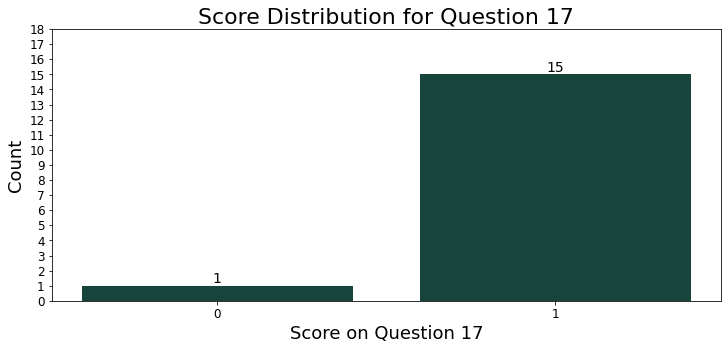

In [89]:
# figure creation cell
# run to create / update figure based on selection above
fig = create_bar(wide_format_data, dropdown_value_widget)

### Saving the Figure

Here's where you will save the figure to your local machine. Please first run the following cell. Then, if your desired file name for the saved figure is different from the default displayed in the text entry box, please change it and then move forward.

NOTE: If you run the cell to display the widgets, then change the value, then try to run the display cell again, you will change the file name value back to the default settings. 

NOTE: if you want the text box to return to default settings, just rerun the cell. 

In [90]:
# Desired file name cell

# RUN ME FIRST
# THEN CHANGE NAME IF NECESSARY

# Text input widget
# this is for inputting the new desired file name
figure_file_name_box = widgets.Text(
    # what appears in the box initially
    value='FigureReproducibilityFigure',
    # what appears in the box when all text is deleted
    placeholder='Enter File Name Here',
    # what the box is labeled on the left
    description='Desired Figure Name (do not include .png)',
    # width of secription
     style={'description_width': 'initial'},
    # text box size 
   layout=widgets.Layout(width='60%', height='80%'),
    disabled=False)

# make the widget actually show up
display(figure_file_name_box)

Text(value='FigureReproducibilityFigure', description='Desired Figure Name (do not include .png)', layout=Layo…

After the above text entry widget holds the desired file name, run the cell below to save the figure as a .png file.

In [91]:
# figure saving cell
# run to save the figure based on selection above and titles based on the text entry box above

fig.savefig(figure_file_name_box.value)

#### All Done! Thank you for following our tutorial. Please reach out with any questions or concerns.